# Modules and Data


In [1]:
# Imports
import polars as pl
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Path
path_to_data = Path.cwd().parent / "data"
assert path_to_data.exists()

# Data
items = pl.read_csv(path_to_data / "items.csv")  # Items data with item's features
users = pl.read_csv(path_to_data / "users.csv")  # Users data with user's features
interactions = pl.read_csv(
    path_to_data / "interactions.csv"
)  # Users' interactions with items
submission_data = pl.read_csv(path_to_data / "submission_sample.csv")

# Data Explorating


## Users


### Age column


In [5]:
# Columns
display(users.head())

print(f"Dataframe columns: {users.columns}")

user_id,age,income,sex,kids_flg
i64,str,str,str,i64
973171,"""age_25_34""","""income_60_90""","""М""",1
962099,"""age_18_24""","""income_20_40""","""М""",0
1047345,"""age_45_54""","""income_40_60""","""Ж""",0
721985,"""age_45_54""","""income_20_40""","""Ж""",0
704055,"""age_35_44""","""income_60_90""","""Ж""",0


Dataframe columns: ['user_id', 'age', 'income', 'sex', 'kids_flg']


In [6]:
users.describe()

statistic,user_id,age,income,sex,kids_flg
str,f64,str,str,str,f64
"""count""",840197.0,"""826102""","""825421""","""826366""",840197.0
"""null_count""",0.0,"""14095""","""14776""","""13831""",0.0
"""mean""",548766.797349,null,null,null,0.301106
"""std""",316884.134955,null,null,null,0.458739
"""min""",0.0,"""age_18_24""","""income_0_20""","""Ж""",0.0
"""25%""",274099.0,null,null,null,0.0
"""50%""",548808.0,null,null,null,0.0
"""75%""",823238.0,null,null,null,1.0
"""max""",1.097558e6,"""age_65_inf""","""income_90_150""","""М""",1.0


- Видим, что имеются пропущенные значения практически по всем колонкам


In [7]:
# Age column statistics
missing_age = users["age"].null_count()
print(f"Number of missing values in age column: {missing_age}")
print(f"Age type: {users.select('age').unique()['age'].to_list()}")
print()

# Lets replace None values with 'unknown'
users = users.with_columns(
    pl.when(pl.col("age").is_null())
    .then(pl.lit("age_non_specified"))
    .otherwise(pl.col("age"))
    .alias("age")
)
print("Age types after replacement: ", users.select("age").unique()["age"].to_list())


Number of missing values in age column: 14095
Age type: ['age_55_64', 'age_35_44', 'age_25_34', 'age_65_inf', None, 'age_45_54', 'age_18_24']

Age types after replacement:  ['age_45_54', 'age_non_specified', 'age_35_44', 'age_55_64', 'age_18_24', 'age_65_inf', 'age_25_34']


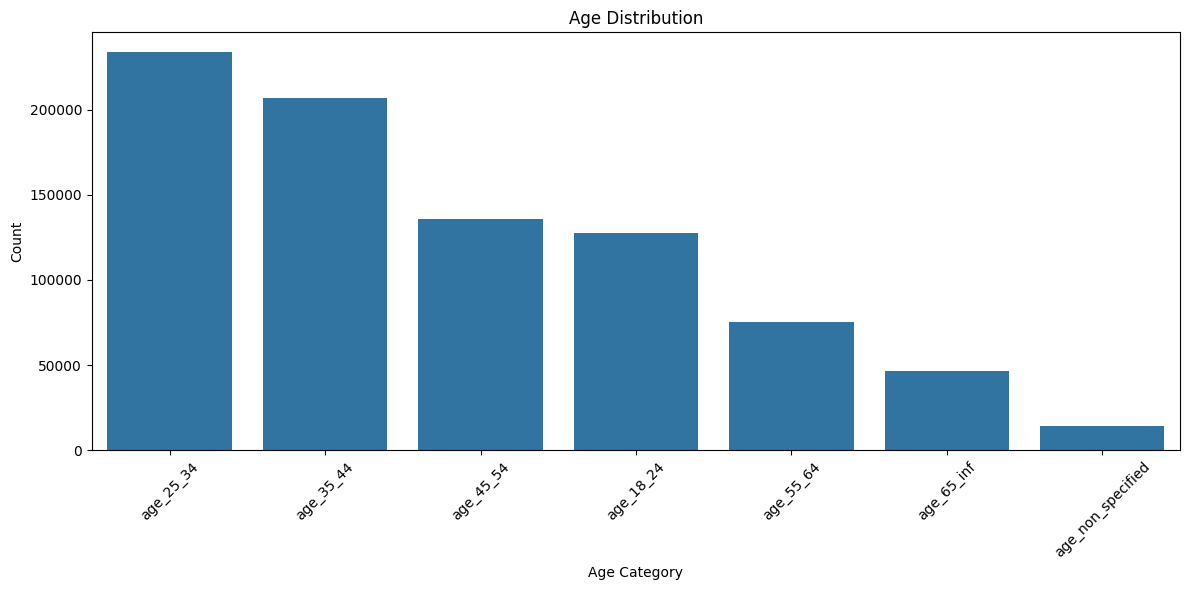

In [8]:
# Age column distribution
age_counts = (
    users.group_by("age").agg(pl.len().alias("count")).sort("count", descending=True)
)


plt.figure(figsize=(12, 6))
sns.barplot(x="age", y="count", data=age_counts)
plt.title("Age Distribution")
plt.xlabel("Age Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# Making age column categorical = Enum type in order to speed up perfomance

age_categories = users.select("age").unique()["age"].to_list()
users = users.with_columns(pl.col("age").cast(pl.Enum(age_categories)).alias("age"))

assert users.select("age").dtypes[0] == pl.Enum

### Sex column


In [10]:
# Checking if any missing values in sex column
print(f"Number of missing values in sex column: {users['sex'].is_null().sum()}")

users = users.with_columns(
    pl.when(pl.col("sex").is_null())
    .then(pl.lit("sex_non_specified"))
    .otherwise(pl.col("sex"))
    .alias("sex")
)

# Translate sex column to English
users = users.with_columns(
    pl.when(pl.col("sex") == "М")
    .then(pl.lit("M"))
    .when(pl.col("sex") == "Ж")
    .then(pl.lit("F"))
    .otherwise(pl.col("sex"))
    .alias("sex")
)

Number of missing values in sex column: 13831


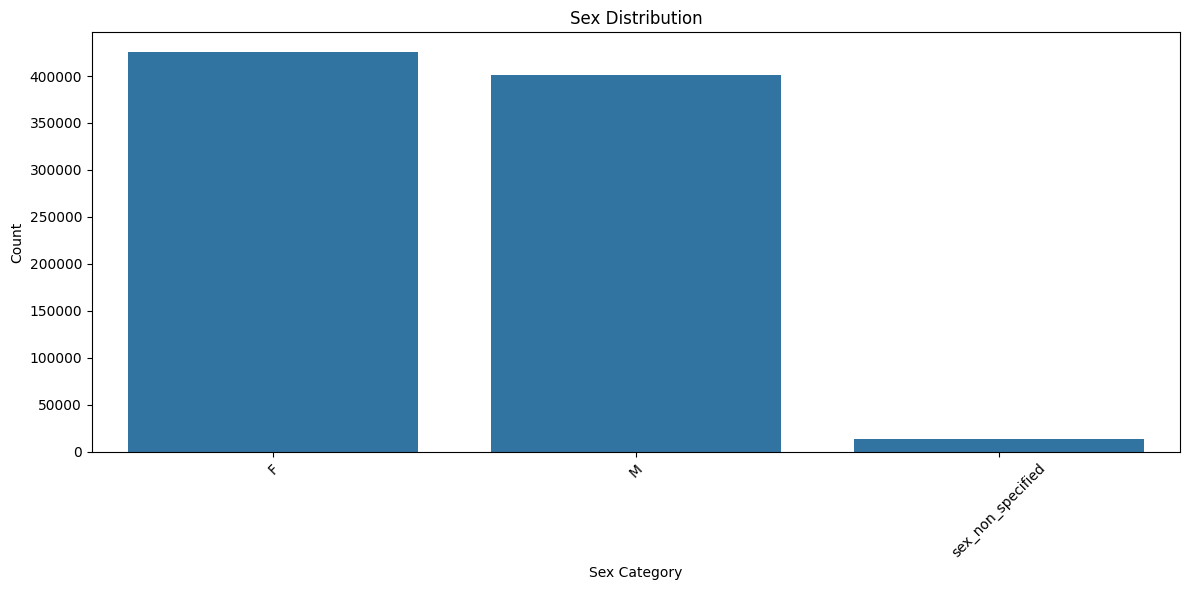

In [11]:
sex_counts = (
    users.group_by("sex").agg(pl.len().alias("count")).sort("count", descending=True)
)


plt.figure(figsize=(12, 6))
sns.barplot(x="sex", y="count", data=sex_counts)
plt.title("Sex Distribution")
plt.xlabel("Sex Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Checking if any missing values in sex column
assert users["sex"].is_null().sum() == 0

In [13]:
# Making Enum type

sex_categories = users.select("sex").unique()["sex"].to_list()
users = users.with_columns(pl.col("sex").cast(pl.Enum(sex_categories)).alias("sex"))

assert users.select("sex").dtypes[0] == pl.Enum

### Income column


In [14]:
# Checking if any missing values in income column
print(f"Number of missing values in income column: {users['income'].is_null().sum()}")

users = users.with_columns(
    pl.when(pl.col("income").is_null())
    .then(pl.lit("income_non_specified"))
    .otherwise(pl.col("income"))
    .alias("income")
)

Number of missing values in income column: 14776


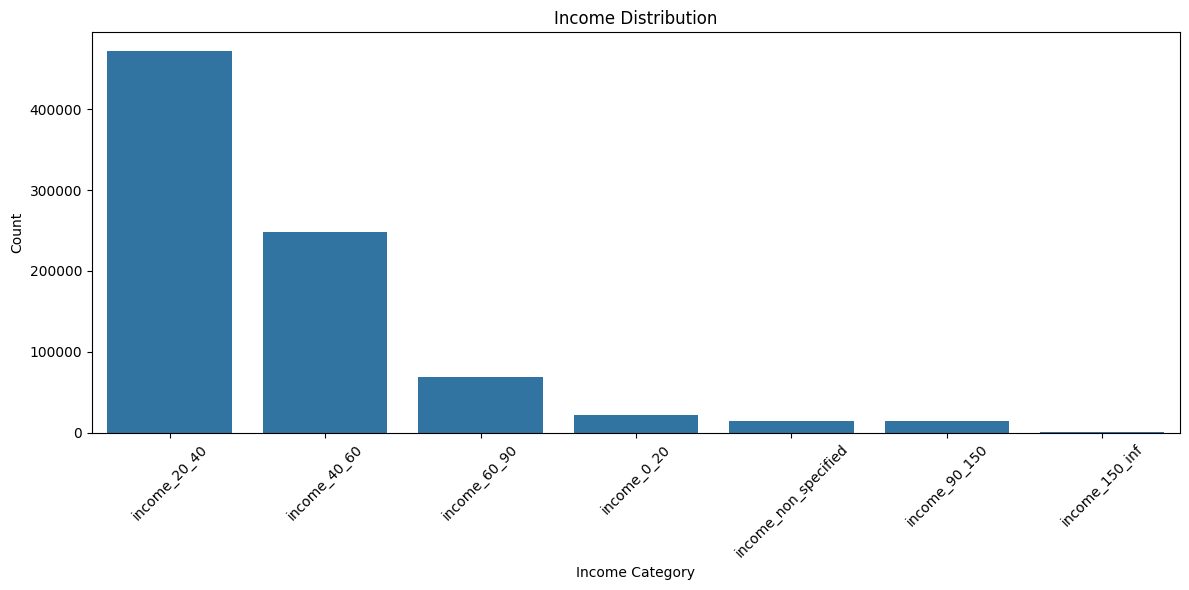

In [15]:
# Plotting income distribution
income_counts = (
    users.group_by("income").agg(pl.len().alias("count")).sort("count", descending=True)
)


plt.figure(figsize=(12, 6))
sns.barplot(x="income", y="count", data=income_counts)
plt.title("Income Distribution")
plt.xlabel("Income Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()

In [16]:
income_categories = users.select("income").unique()["income"].to_list()
users = users.with_columns(
    pl.col("income").cast(pl.Enum(income_categories)).alias("income")
)

assert users.select("income").dtypes[0] == pl.Enum


### Kids column


In [17]:
print(f"Number of missing values in kids column: {users['kids_flg'].is_null().sum()}")

Number of missing values in kids column: 0


- Так как нет пропущенных значений, то просто посмотрим на распределение и заменим тип данных


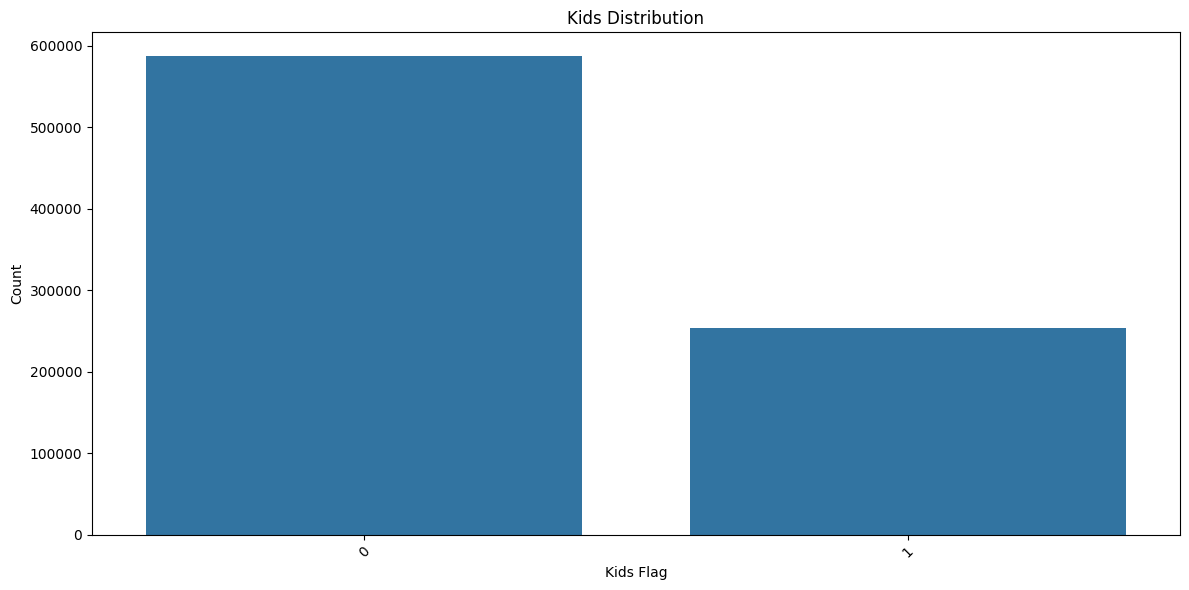

In [18]:
users_kinds_count = (
    users.group_by("kids_flg")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)

plt.figure(figsize=(12, 6))
sns.barplot(x="kids_flg", y="count", data=users_kinds_count)
plt.title("Kids Distribution")
plt.xlabel("Kids Flag")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()

In [19]:
users = users.with_columns(pl.col("kids_flg").cast(pl.Boolean).alias("kids_flg"))

assert users.select("kids_flg").dtypes[0] == pl.Boolean

### Users Final Overview


In [20]:
# Print users schema
for column, column_type in users.schema.items():
    print(f"{column}: {column_type}")
print()

# Check for any missing values across all columns
missing_values = users.null_count()
print(missing_values)


user_id: Int64
age: Enum(categories=['age_55_64', 'age_65_inf', 'age_18_24', 'age_45_54', 'age_25_34', 'age_non_specified', 'age_35_44'])
income: Enum(categories=['income_150_inf', 'income_60_90', 'income_20_40', 'income_non_specified', 'income_0_20', 'income_40_60', 'income_90_150'])
sex: Enum(categories=['M', 'sex_non_specified', 'F'])
kids_flg: Boolean

shape: (1, 5)
┌─────────┬─────┬────────┬─────┬──────────┐
│ user_id ┆ age ┆ income ┆ sex ┆ kids_flg │
│ ---     ┆ --- ┆ ---    ┆ --- ┆ ---      │
│ u32     ┆ u32 ┆ u32    ┆ u32 ┆ u32      │
╞═════════╪═════╪════════╪═════╪══════════╡
│ 0       ┆ 0   ┆ 0      ┆ 0   ┆ 0        │
└─────────┴─────┴────────┴─────┴──────────┘


- Супер!


## Items


In [3]:
items.head()

item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
i64,str,str,str,f64,str,str,f64,f64,str,str,str,str,str
10711,"""film""","""Поговори с ней""","""Hable con ella""",2002.0,"""драмы, зарубежные, детективы, …","""Испания""",null,16.0,null,"""Педро Альмодовар""","""Адольфо Фернандес, Ана Фернанд…","""Мелодрама легендарного Педро А…","""Поговори, ней, 2002, Испания, …"
2508,"""film""","""Голые перцы""","""Search Party""",2014.0,"""зарубежные, приключения, комед…","""США""",null,16.0,null,"""Скот Армстронг""","""Адам Палли, Брайан Хаски, Дж.Б…","""Уморительная современная комед…","""Голые, перцы, 2014, США, друзь…"
10716,"""film""","""Тактическая сила""","""Tactical Force""",2011.0,"""криминал, зарубежные, триллеры…","""Канада""",null,16.0,null,"""Адам П. Калтраро""","""Адриан Холмс, Даррен Шалави, Д…","""Профессиональный рестлер Стив …","""Тактическая, сила, 2011, Канад…"
7868,"""film""","""45 лет""","""45 Years""",2015.0,"""драмы, зарубежные, мелодрамы""","""Великобритания""",null,16.0,null,"""Эндрю Хэй""","""Александра Риддлстон-Барретт, …","""Шарлотта Рэмплинг, Том Кортни,…","""45, лет, 2015, Великобритания,…"
16268,"""film""","""Все решает мгновение""",null,1978.0,"""драмы, спорт, советские, мелод…","""СССР""",null,12.0,"""Ленфильм""","""Виктор Садовский""","""Александр Абдулов, Александр Д…","""Расчетливая чаровница из совет…","""Все, решает, мгновение, 1978, …"


In [22]:
# Print item schema
for column, column_type in items.schema.items():
    print(f"{column}: {column_type}")
print()

item_id: Int64
content_type: String
title: String
title_orig: String
release_year: Float64
genres: String
countries: String
for_kids: Float64
age_rating: Float64
studios: String
directors: String
actors: String
description: String
keywords: String



### Content type


In [23]:
print(f"Content type unique values: {items['content_type'].unique().to_list()}")
print(f"Missing values in content type column: {items['content_type'].is_null().sum()}")

Content type unique values: ['series', 'film']
Missing values in content type column: 0


In [24]:
# Making content type column categorical

content_type_categories = (
    items.select("content_type").unique()["content_type"].to_list()
)
items = items.with_columns(
    pl.col("content_type").cast(pl.Enum(content_type_categories)).alias("content_type")
)

In [25]:
# Asserts
assert items.select("content_type").dtypes[0] == pl.Enum
assert items["content_type"].null_count() == 0


### Title


In [26]:
print(f"Sample of 10 title values: {items['title'].sample(5).to_list()}")

print(f"Missing values in title column: {items['title'].is_null().sum()}")

print(
    f"Duplicate titles: {items.filter(pl.col('title').is_not_null()).select('title').is_duplicated().sum()}"
)

# Топ 10 films
top_10_duplicated_titles = (
    items.filter(pl.col("title").is_not_null())
    .group_by("title")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .head(10)
)
print("\nTop 10 duplicated titles:")
print(top_10_duplicated_titles)

Sample of 10 title values: ['Малена', 'Одинокая женщина желает познакомиться', 'Огромные формы', 'Санта на обучении (на английском языке с русскими субтитрами)', 'Чужие: Вторжение']
Missing values in title column: 0
Duplicate titles: 1266

Top 10 duplicated titles:
shape: (10, 2)
┌──────────────────────┬───────┐
│ title                ┆ count │
│ ---                  ┆ ---   │
│ str                  ┆ u32   │
╞══════════════════════╪═══════╡
│ Охота                ┆ 5     │
│ Ева                  ┆ 4     │
│ Вторжение            ┆ 4     │
│ Стрелок              ┆ 4     │
│ Родина               ┆ 4     │
│ Соблазн              ┆ 4     │
│ Красавица и чудовище ┆ 4     │
│ Возмездие            ┆ 4     │
│ Герой                ┆ 3     │
│ Она                  ┆ 3     │
└──────────────────────┴───────┘


- Сразу видно, что формат названия разнится от фильма к фильму - нужно уравнять подход
- Есть дубликаты


In [27]:
# Let's refactor titles

# Make them lowercase and strip whitespace
items = items.with_columns(
    pl.col("title").str.to_lowercase().str.strip_chars().alias("title")
)

In [28]:
# Asserts
assert items["title"].null_count() == 0

### Title orig


In [29]:
print(f"Sample of 10 title orig values: \n{items['title_orig'].sample(5).to_list()}")
print()
print(f"Missing values in title orig column: {items['title_orig'].is_null().sum()}")

Sample of 10 title orig values: 
['Last Week Tonight with John Oliver', None, None, 'No dice! (Sign Language)', 'Boonie Bears: The Adventurers']

Missing values in title orig column: 4745


In [30]:
# Fillna None values with 'Unknown" string
items = items.with_columns(
    pl.when(pl.col("title_orig").is_null())
    .then(pl.lit("Unknown"))
    .otherwise(pl.col("title_orig"))
    .alias("title_orig")
)


In [31]:
# See top 10 titles by count

top_10_titles_by_count = (
    items.filter(pl.col("title_orig").is_not_null())
    .group_by("title_orig")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .head(10)
)
print("\nTop 10 titles by count:")
print(top_10_titles_by_count)


Top 10 titles by count:
shape: (10, 2)
┌──────────────────────┬───────┐
│ title_orig           ┆ count │
│ ---                  ┆ ---   │
│ str                  ┆ u32   │
╞══════════════════════╪═══════╡
│ Unknown              ┆ 4745  │
│ Pet Sematary         ┆ 4     │
│ Little Women         ┆ 4     │
│ Traditional dance    ┆ 4     │
│ Star Trek            ┆ 3     │
│ V2. Escape from Hell ┆ 3     │
│ Victoria             ┆ 3     │
│ Great Expectations   ┆ 3     │
│ King Kong            ┆ 3     │
│ Body Cam             ┆ 3     │
└──────────────────────┴───────┘


In [32]:
# Lets see original title and title_orig for top 10 titles

top_10_titles = (
    items.filter(pl.col("title_orig").is_not_null())
    .select("title", "title_orig")
    .head(10)
)
print("\nTop 10 titles:")
print(top_10_titles)


Top 10 titles:
shape: (10, 2)
┌─────────────────────────────────┬─────────────────────────────────┐
│ title                           ┆ title_orig                      │
│ ---                             ┆ ---                             │
│ str                             ┆ str                             │
╞═════════════════════════════════╪═════════════════════════════════╡
│ поговори с ней                  ┆ Hable con ella                  │
│ голые перцы                     ┆ Search Party                    │
│ тактическая сила                ┆ Tactical Force                  │
│ 45 лет                          ┆ 45 Years                        │
│ все решает мгновение            ┆ Unknown                         │
│ северо-юг                       ┆ Unknown                         │
│ марья-искусница                 ┆ Unknown                         │
│ принцесса лебедь: пират или пр… ┆ The Swan Princess: Princess To… │
│ лабиринты прошлого              ┆ Todos lo saben         

In [33]:
# Lowercase title_orig and strip whitespace
items = items.with_columns(
    pl.col("title_orig").str.to_lowercase().str.strip_chars().alias("title_orig")
)


- Интересно, как некоторые фильмы совсем не похожи на оригинальное название


In [34]:
# Asserts
assert items["title_orig"].null_count() == 0

### Release year


In [35]:
print(f"Sample of 10 release year values: {items['release_year'].sample(5).to_list()}")
print(f"Missing values in release year column: {items['release_year'].is_null().sum()}")
print()
print(f"Min release year: {items['release_year'].min()}")
print(f"Max release year: {items['release_year'].max()}")

Sample of 10 release year values: [1995.0, 2006.0, 2015.0, 2011.0, 2019.0]
Missing values in release year column: 98

Min release year: 1897.0
Max release year: 2021.0


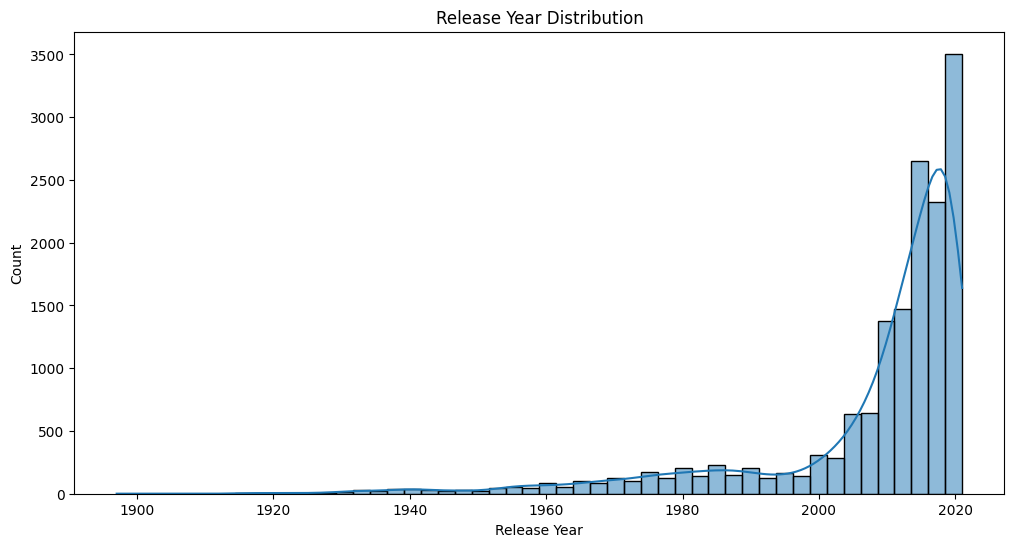

In [36]:
# Histogram of release year
plt.figure(figsize=(12, 6))
sns.histplot(items["release_year"], bins=50, kde=True)
plt.title("Release Year Distribution")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.show()

In [37]:
# Set arbitrary release year for null values (for example 2020)
items = items.with_columns(
    pl.when(pl.col("release_year").is_null())
    .then(pl.lit(2020))
    .otherwise(pl.col("release_year"))
    .alias("release_year")
)

# Create decade ranges for release years
items = items.with_columns(
    pl.when(pl.col("release_year") < 1920)
    .then(pl.lit("pre_1920"))
    .when(pl.col("release_year") >= 2020)
    .then(pl.lit("post_2020"))
    .otherwise(
        pl.concat_str(
            [
                ((pl.col("release_year").cast(pl.Int64) // 10) * 10).cast(pl.Utf8),
                pl.lit("-"),
                ((pl.col("release_year").cast(pl.Int64) // 10) * 10 + 10).cast(pl.Utf8),
            ]
        )
    )
    .alias("release_year_range")
)


In [38]:
items.filter(pl.col("release_year") >= 2020)["release_year_range"].unique()

release_year_range
str
"""post_2020"""


In [39]:
# Making release_year_range column categorical

release_year_range_categories = (
    items.select("release_year_range").unique()["release_year_range"].to_list()
)

items = items.with_columns(
    pl.col("release_year_range")
    .cast(pl.Enum(release_year_range_categories))
    .alias("release_year_range")
)


In [40]:
# Values counts for release_year_range
items.group_by("release_year_range").agg(pl.len().alias("count")).sort(
    "count", descending=True
)


release_year_range,count
enum,u32
"""2010-2020""",8788
"""post_2020""",2276
"""2000-2010""",2168
"""1980-1990""",745
"""1990-2000""",636
…,…
"""1950-1960""",199
"""1940-1950""",117
"""1930-1940""",104


In [41]:
# Example of release_year_range
items["release_year", "release_year_range", "title"]

release_year,release_year_range,title
f64,enum,str
2002.0,"""2000-2010""","""поговори с ней"""
2014.0,"""2010-2020""","""голые перцы"""
2011.0,"""2010-2020""","""тактическая сила"""
2015.0,"""2010-2020""","""45 лет"""
1978.0,"""1970-1980""","""все решает мгновение"""
…,…,…
2018.0,"""2010-2020""","""полярный круг"""
2020.0,"""post_2020""","""надежда"""
2017.0,"""2010-2020""","""сговор"""


In [42]:
# Asserts
assert items.select("release_year_range").dtypes[0] == pl.Enum
assert items["release_year_range"].null_count() == 0

### Genres


In [43]:
print(f"Sample of 10 genres values: {items['genres'].sample(5).to_list()}")
print(f"Missing values in genres column: {items['genres'].is_null().sum()}")




Sample of 10 genres values: ['документальное', 'драмы, зарубежные, триллеры', 'ужасы, зарубежные', 'военные', 'мелодрамы, комедии']
Missing values in genres column: 0


- Категории уже в нижнем регистре, поэтому нет смысла их менять
- Нет дубликатов


In [44]:
# Making genres column categorical

genres_categories = items.select("genres").unique()["genres"].to_list()

items = items.with_columns(
    pl.col("genres").cast(pl.Enum(genres_categories)).alias("genres")
)


In [45]:
# Asserts
assert items.select("genres").dtypes[0] == pl.Enum
assert items["genres"].null_count() == 0

### Country


In [46]:
print(f"Sample of 10 country values: {items['countries'].sample(10).to_list()}")
print(f"Missing values in country column: {items['countries'].is_null().sum()}")

Sample of 10 country values: ['Россия', 'Чехия', 'США', 'Россия', 'Россия', 'Австралия, США', 'Великобритания', 'Великобритания', 'Италия', 'Россия']
Missing values in country column: 37


- Видно, что идет перечисление стран в одной строке
- Есть дубликаты


In [47]:
# Display rows with missing country values
items.filter(pl.col("countries").is_null()).sample(5)


item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_range
i64,enum,str,str,f64,enum,str,f64,f64,str,str,str,str,str,enum
15938,"""series""","""капуки дети и родители""","""unknown""",2019.0,"""развлекательные, для детей, ру…",null,null,0.0,null,null,null,"""Серия развлекательных и познав…","""Капуки, дети, родители, 2019, …","""2010-2020"""
12295,"""series""","""разговоры животных""","""animal conversations""",2021.0,"""документальное""",null,null,18.0,null,null,null,"""Документальный проект, помогаю…","""Разговоры, животных, 2021""","""post_2020"""
11178,"""series""","""развитие гибкости всего тела""","""unknown""",2021.0,"""фитнес, спорт""",null,null,6.0,null,null,null,"""Программа от Motify для тех, к…","""Развитие, гибкости, всего, тел…","""post_2020"""
8963,"""film""","""брайан стивенсон: борьба за ра…","""true justice: bryan stevenson'…",2019.0,"""документальное""",null,null,16.0,null,"""Джордж Кунхардт, Питер У. Кунх…","""Брайан Стивенсон""","""Если бы Брайан Стивенсон был с…","""Брайан, Стивенсон, Борьба, за,…","""2010-2020"""
9958,"""series""","""программа рационального питани…","""unknown""",2021.0,"""фитнес, спорт""",null,null,6.0,null,null,null,"""Motify составил несколько прим…","""Программа, рационального, пита…","""post_2020"""


- Какие-то фитнес фильмы/ программы с явно русским названием
- Проставим им Россию


In [48]:
# Filling missing countries with Russia
items = items.with_columns(
    pl.when(pl.col("countries").is_null())
    .then(pl.lit("Россия"))
    .otherwise(pl.col("countries"))
    .alias("countries")
)

# Lower case countries
items = items.with_columns(pl.col("countries").str.to_lowercase().alias("countries"))

# Column preparation
items = items.with_columns(
    pl.col("countries")
    .str.split(", ")
    .list.unique()
    .list.sort()
    .list.join(", ")
    .alias("countries")
)

In [49]:
# Asserts

assert items.select("countries").dtypes[0] == pl.Utf8
assert items["countries"].null_count() == 0

### For kids


In [50]:
# Check for missing values
display(items["for_kids"].value_counts())

print(f"Missing values in for_kids column: {items['for_kids'].is_null().sum()}")

for_kids,count
f64,u32
1.0,114
0.0,452
null,15397


Missing values in for_kids column: 15397


In [51]:
items.filter(pl.col("for_kids").is_null()).sample(2)

item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_range
i64,enum,str,str,f64,enum,str,f64,f64,str,str,str,str,str,enum
14782,"""film""","""100 футов""","""100 feet""",2008.0,"""зарубежные, триллеры, детектив…","""сша""",null,16.0,null,"""Эрик Ред""","""Бобби Каннавале, Джон Фэллон, …","""Жестокому насильнику-полицейск…","""100, футов, 2008, США, месть, …","""2000-2010"""
3076,"""film""","""земля кочевников (субтитры)""","""nomadland""",2020.0,"""драмы""","""германия, сша""",null,16.0,null,"""Хлоя Чжао""","""Фрэнсис МакДорманд, Гэй ДеФоре…","""Лауреат Венецианского кинофест…","""фабричный рабочий, по роману и…","""post_2020"""


In [52]:
items = items.with_columns(
    pl.when(pl.col("for_kids").is_null())
    .then(pl.lit(0))
    .otherwise(pl.col("for_kids"))
    .cast(pl.Boolean)
    .alias("for_kids")
)

In [53]:
# Asserts
assert items.select("for_kids").dtypes[0] == pl.Boolean
assert items["for_kids"].null_count() == 0


### Age rating


In [54]:
print(f"Sample of 10 age rating values: {items['age_rating'].sample(10).to_list()}")
print(f"Missing values in age rating column: {items['age_rating'].is_null().sum()}")

Sample of 10 age rating values: [6.0, 12.0, 0.0, 16.0, 12.0, 6.0, 12.0, 16.0, 18.0, 6.0]
Missing values in age rating column: 2


In [55]:
print("top 10 age rating:")
top_10_age_rating = (
    items.group_by("age_rating")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .head(10)
)
print(top_10_age_rating)

top 10 age rating:
shape: (7, 2)
┌────────────┬───────┐
│ age_rating ┆ count │
│ ---        ┆ ---   │
│ f64        ┆ u32   │
╞════════════╪═══════╡
│ 16.0       ┆ 5729  │
│ 12.0       ┆ 4147  │
│ 18.0       ┆ 2547  │
│ 6.0        ┆ 1538  │
│ 0.0        ┆ 1518  │
│ 21.0       ┆ 482   │
│ null       ┆ 2     │
└────────────┴───────┘


In [56]:
items.filter(pl.col("age_rating").is_null())

item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_range
i64,enum,str,str,f64,enum,str,bool,f64,str,str,str,str,str,enum
6316,"""series""","""машины-помощники""","""unknown""",2016.0,"""русские, для детей, сериалы, х…","""россия""",false,null,null,null,null,"""Маленькие мальчики всего мира …","""Машины-помощники, 2017, Россия…","""2010-2020"""
14409,"""series""","""бибабу""","""unknown""",2017.0,"""русские, сериалы, для детей, х…","""россия""",false,null,null,null,null,"""В сказочное подводное царство …","""друзья, магия и волшебство, ры…","""2010-2020"""


- Явно детское содержание


In [57]:
items = items.with_columns(
    pl.when(pl.col("age_rating").is_null())
    .then(pl.lit(0))
    .otherwise(pl.col("age_rating"))
    .alias("age_rating")
)

# Making age rating column categorical

age_rating_categories = (
    items.select(pl.col("age_rating").cast(pl.Utf8)).unique()["age_rating"].to_list()
)

items = items.with_columns(
    pl.col("age_rating")
    .cast(pl.Utf8)
    .cast(pl.Enum(age_rating_categories))
    .alias("age_rating")
)


In [58]:
assert items.select("age_rating").dtypes[0] == pl.Enum
assert items["age_rating"].null_count() == 0

### Studios


In [59]:
# Filling missing studios with unknown
items = items.with_columns(
    pl.when(pl.col("studios").is_null())
    .then(pl.lit("unknown"))
    .otherwise(pl.col("studios"))
    .alias("studios")
)

# Lowercase studios
items = items.with_columns(pl.col("studios").str.to_lowercase().alias("studios"))

# Column preparation
items = items.with_columns(
    pl.col("studios")
    .str.split(", ")
    .list.unique()
    .list.sort()
    .list.join(", ")
    .alias("studios")
)

In [60]:
# Making studios column categorical

studios_categories = items.select("studios").unique()["studios"].to_list()

items = items.with_columns(
    pl.col("studios").cast(pl.Enum(studios_categories)).alias("studios")
)

In [61]:
# Asserts
assert items.select("studios").dtypes[0] == pl.Enum
assert items["studios"].null_count() == 0

### Directors


In [62]:
items = items.with_columns(
    pl.when(pl.col("directors").is_null())
    .then(pl.lit("unknown"))
    .otherwise(pl.col("directors"))
    .alias("directors")
)

# Lowercase directors
items = items.with_columns(pl.col("directors").str.to_lowercase().alias("directors"))


# Making directors column categorical

directors_categories = items.select("directors").unique()["directors"].to_list()

items = items.with_columns(
    pl.col("directors").cast(pl.Enum(directors_categories)).alias("directors")
)

In [63]:
# asserts

assert items.select("directors").dtypes[0] == pl.Enum
assert items["directors"].null_count() == 0

### Actors


In [64]:
# Filling missing actors with unknown
items = items.with_columns(
    pl.when(pl.col("actors").is_null())
    .then(pl.lit("unknown"))
    .otherwise(pl.col("actors"))
    .alias("actors")
)

# Making actors column categorical
actors_categories = items.select("actors").unique()["actors"].to_list()

items = items.with_columns(
    pl.col("actors").cast(pl.Enum(actors_categories)).alias("actors")
)

In [65]:
# asserts

assert items.select("actors").dtypes[0] == pl.Enum
assert items["actors"].null_count() == 0

### Keywords


In [66]:
# Filling missing keywords with unknown
items = items.with_columns(
    pl.when(pl.col("keywords").is_null())
    .then(pl.lit("unknown"))
    .otherwise(pl.col("keywords"))
    .alias("keywords")
)


In [67]:
items["keywords"].sample(5).to_list()

['Последнее, дело, Ламарки, 2002, США',
 'подслушано, подслушано в контакте, социальная сеть, социальные медиа, интернет, онлайн, паблик, паблик вк, илья куликов, илья кулик, подслушн, подслуш, подслушано сериал, сериал подслушано илья куликов, сериал подслушано 2021, подслушано смотреть онлайн, подслушано сериал бесплатно, подслушано 2021, сериалы 2021, смотреть сериалы 2021, сериалы онлайн 2021, сериалы 2021 русские, российские сериалы 2021, сериалы про подростков, сериалы для подростков, маньяк сериал, сериалы про маньяков, фильмы похожие на пилу, очень странные дела похожие, сериалы похожие на очень странные дела, фильмы похожие на лето 84, оно похожие фильмы, дети расследование, сериалы про расследование подростков, сериалы про подростков детектив, психологические триллеры, лучшие психологические триллеры, подростковое кино, исчезновение детей, пропажа детей, смерть ребенка, игра на выживание, смотреть игра на выживание, игры выживание онлайн, джулс, нокс, одноклассники, сериалы п

### Description


In [68]:
# Filling missing description with -
items = items.with_columns(
    pl.when(pl.col("description").is_null())
    .then(pl.lit("-"))
    .otherwise(pl.col("description"))
    .alias("description")
)

### General check


In [69]:
# Check for duplicates
assert items["item_id"].is_duplicated().sum() == 0
assert items["title"].is_duplicated().sum() == 1300

duplicated_items = items.filter(
    items.select(["content_type", "countries", "title", "directors"]).is_duplicated()
)

duplicated_items

item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_range
i64,enum,str,str,f64,enum,str,bool,enum,enum,enum,enum,str,str,enum
13787,"""film""","""пираты по соседству""","""pirates down the street""",2020.0,"""семейное, приключения""","""нидерланды""",false,"""12.0""","""unknown""","""пим ван хёве""","""Матти Стукер, Самуэль Бо Ройре…","""В скучном городке Линдсборо вс…","""2020, нидерланды, пираты, по, …","""post_2020"""
12889,"""film""","""пираты по соседству""","""de piraten van hiernaast""",2020.0,"""фильмы, для детей, приключения…","""нидерланды""",false,"""12.0""","""unknown""","""пим ван хёве""","""Берт Хана, Дэвид Люсиер, Матти…","""Самый тихий городок на свете п…","""Пираты, по, соседству, 2020, Н…","""post_2020"""


In [70]:
for col, type_col in duplicated_items.schema.items():
    print(f"{col}: {type_col.__class__}")


item_id: Int64
content_type: Enum
title: String
title_orig: String
release_year: Float64
genres: Enum
countries: String
for_kids: Boolean
age_rating: Enum
studios: Enum
directors: Enum
actors: Enum
description: String
keywords: String
release_year_range: Enum


## Interactions


In [71]:
# Sample
display(interactions.head())

# Missing values
print(interactions.null_count())

user_id,item_id,last_watch_dt,total_dur,watched_pct
i64,i64,str,i64,f64
176549,9506,"""2021-05-11""",4250,72.0
699317,1659,"""2021-05-29""",8317,100.0
656683,7107,"""2021-05-09""",10,0.0
864613,7638,"""2021-07-05""",14483,100.0
964868,9506,"""2021-04-30""",6725,100.0


shape: (1, 5)
┌─────────┬─────────┬───────────────┬───────────┬─────────────┐
│ user_id ┆ item_id ┆ last_watch_dt ┆ total_dur ┆ watched_pct │
│ ---     ┆ ---     ┆ ---           ┆ ---       ┆ ---         │
│ u32     ┆ u32     ┆ u32           ┆ u32       ┆ u32         │
╞═════════╪═════════╪═══════════════╪═══════════╪═════════════╡
│ 0       ┆ 0       ┆ 0             ┆ 0         ┆ 828         │
└─────────┴─────────┴───────────────┴───────────┴─────────────┘


- Видно, что есть пропущенные данные у watched_pct


### Watched pct


In [72]:
interactions["watched_pct"].describe()

statistic,value
str,f64
"""count""",5.475423e6
"""null_count""",828.0
"""mean""",46.374002
"""std""",41.918525
"""min""",0.0
"""25%""",4.0
"""50%""",32.0
"""75%""",100.0
"""max""",100.0


In [73]:
interactions.filter(pl.col("watched_pct").is_null())

# Fill with zero null values
interactions = interactions.with_columns(
    pl.when(pl.col("watched_pct").is_null())
    .then(pl.lit(0))
    .otherwise(pl.col("watched_pct"))
    .alias("watched_pct")
)


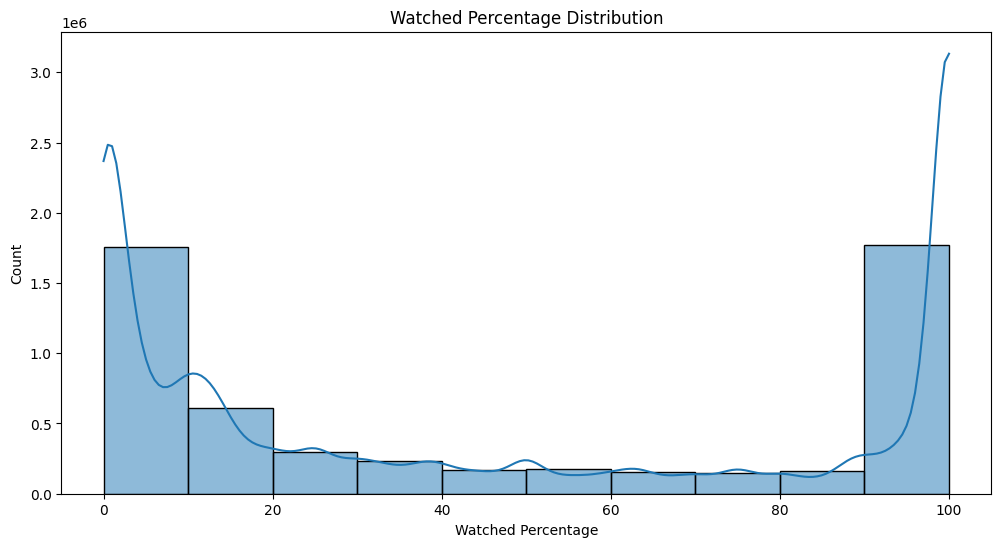

In [74]:
# Histogram of watched_pct

plt.figure(figsize=(12, 6))
sns.histplot(interactions["watched_pct"], bins=10, kde=True)
plt.title("Watched Percentage Distribution")
plt.xlabel("Watched Percentage")
plt.ylabel("Count")
plt.show()

### Total duration


In [75]:
print(interactions["total_dur"].describe())

print(
    f"Number of null values in total_dur column: {interactions.filter(pl.col('total_dur').is_null()).shape[0]}"
)

shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 5.476251e6   │
│ null_count ┆ 0.0          │
│ mean       ┆ 8295.490219  │
│ std        ┆ 48567.992521 │
│ min        ┆ 1.0          │
│ 25%        ┆ 371.0        │
│ 50%        ┆ 2898.0       │
│ 75%        ┆ 7116.0       │
│ max        ┆ 8.0411672e7  │
└────────────┴──────────────┘
Number of null values in total_dur column: 0


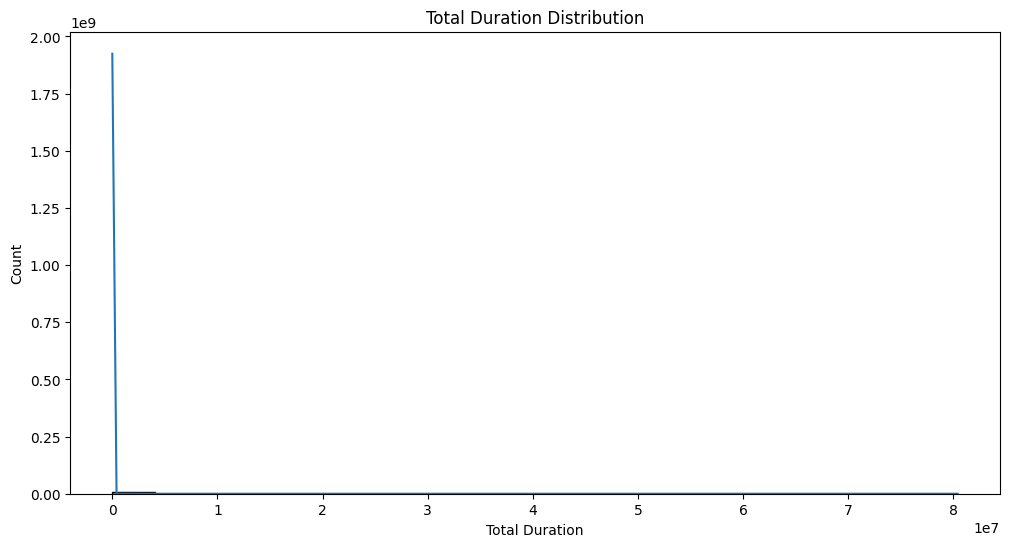

In [76]:
plt.figure(figsize=(12, 6))
sns.histplot(interactions["total_dur"], bins=20, kde=True)
plt.title("Total Duration Distribution")
plt.xlabel("Total Duration")
plt.ylabel("Count")
plt.show()

- Есть выбросы, возьмем 95 перцентиль


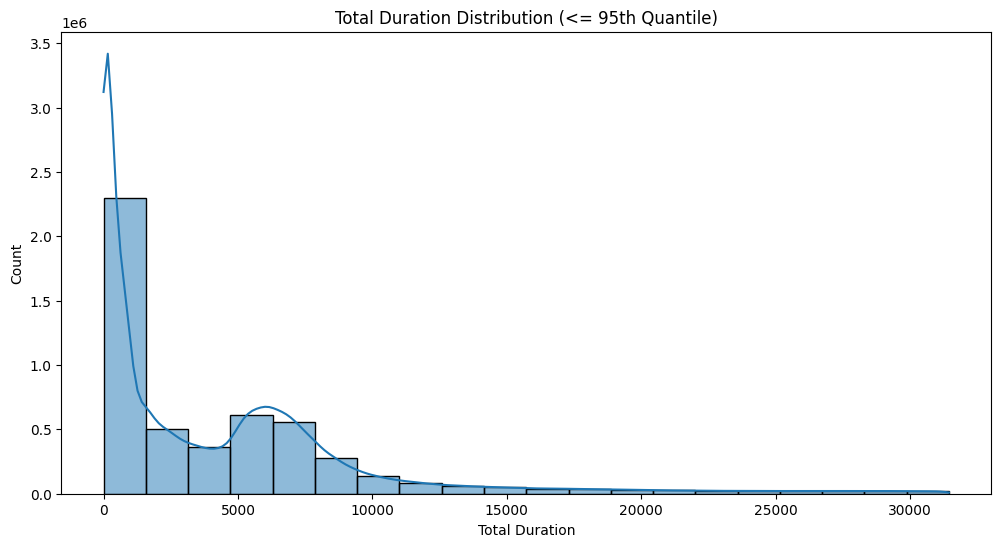

In [77]:
# Pick until 95% percentile
q95 = interactions["total_dur"].quantile(0.95)
plt.figure(figsize=(12, 6))
sns.histplot(
    interactions.filter(pl.col("total_dur") <= q95)["total_dur"], bins=20, kde=True
)
plt.title("Total Duration Distribution (<= 95th Quantile)")
plt.xlabel("Total Duration")
plt.ylabel("Count")
plt.show()


### Last watch date


In [78]:
print(f" Current dtype: {interactions['last_watch_dt'].dtype}")

interactions["last_watch_dt"].sample(1)

 Current dtype: String


last_watch_dt
str
"""2021-08-06"""


In [79]:
# Convert to datetime
interactions = interactions.with_columns(
    pl.col("last_watch_dt").str.to_datetime("%Y-%m-%d").alias("last_watch_dt")
)

print(f" Current dtype: {interactions['last_watch_dt'].dtype}")

 Current dtype: Datetime(time_unit='us', time_zone=None)


In [80]:
interactions["last_watch_dt"].sample(1)

last_watch_dt
datetime[μs]
2021-05-17 00:00:00


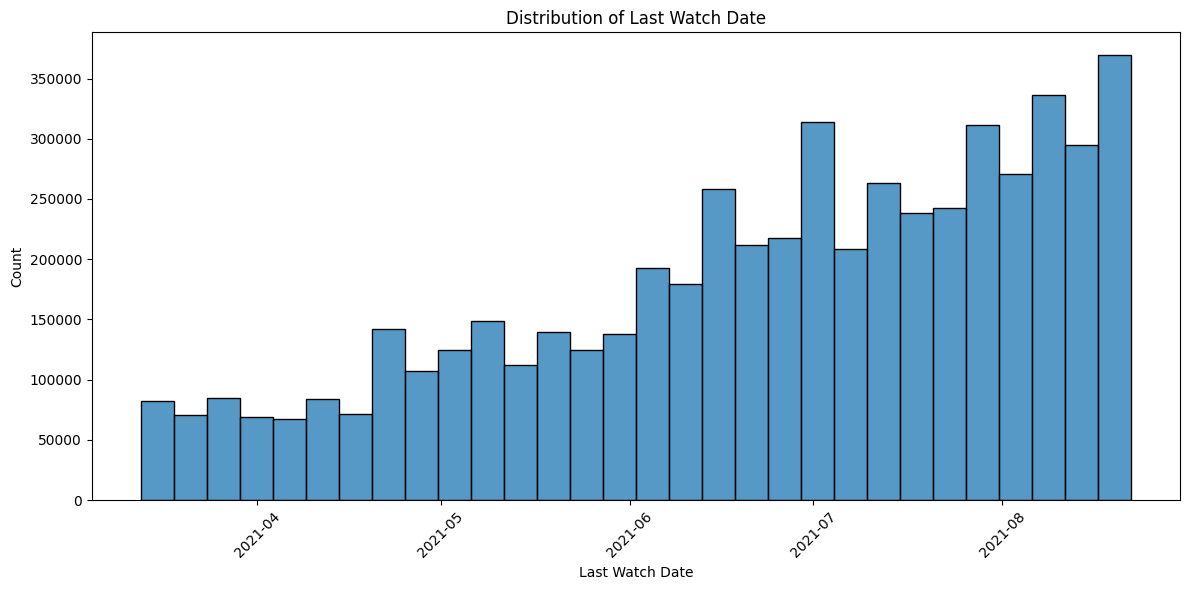

In [81]:
plt.figure(figsize=(12, 6))
sns.histplot(interactions["last_watch_dt"], bins=30, kde=False)
plt.title("Distribution of Last Watch Date")
plt.xlabel("Last Watch Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Iteractions overall check


In [82]:
# Check iteractions for nulls
assert interactions.null_count().to_numpy().sum() == 0

for col, type_col in interactions.schema.items():
    print(f"{col}: {type_col.__class__}")

user_id: Int64
item_id: Int64
last_watch_dt: Datetime
total_dur: Int64
watched_pct: Float64


## Data insights


In [83]:
users.head(1)

user_id,age,income,sex,kids_flg
i64,enum,enum,enum,bool
973171,"""age_25_34""","""income_60_90""","""M""",true


In [84]:
items.head(1)

item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_range
i64,enum,str,str,f64,enum,str,bool,enum,enum,enum,enum,str,str,enum
10711,"""film""","""поговори с ней""","""hable con ella""",2002.0,"""драмы, зарубежные, детективы, …","""испания""",false,"""16.0""","""unknown""","""педро альмодовар""","""Адольфо Фернандес, Ана Фернанд…","""Мелодрама легендарного Педро А…","""Поговори, ней, 2002, Испания, …","""2000-2010"""


In [85]:
interactions.head(1)

user_id,item_id,last_watch_dt,total_dur,watched_pct
i64,i64,datetime[μs],i64,f64
176549,9506,2021-05-11 00:00:00,4250,72.0


In [86]:
# Users
interaction_users = interactions["user_id"].unique()
initial_users = users["user_id"].unique()

comm_users = set(interaction_users) & set(initial_users)
users_only_interactions = set(interaction_users) - set(initial_users)
users_only_features = set(initial_users) - set(interaction_users)


total_amount_of_useres = (
    len(comm_users) + len(users_only_interactions) + len(users_only_features)
)

print(f"Total amount of users: {total_amount_of_useres}")
print(
    f"Users with interactions only: {len(users_only_interactions)} ({len(users_only_interactions) / total_amount_of_useres:.2%})"
)
print(
    f"Users with features only: {len(users_only_features)} ({len(users_only_features) / total_amount_of_useres:.2%})"
)
print(
    f"Users with both features and interactions: {len(comm_users)} ({len(comm_users) / total_amount_of_useres:.2%})"
)


Total amount of users: 1058088
Users with interactions only: 217891 (20.59%)
Users with features only: 95909 (9.06%)
Users with both features and interactions: 744288 (70.34%)


In [87]:
# Items

interaction_items = interactions["item_id"].unique()
initial_items = items["item_id"].unique()

comm_items = set(interaction_items) & set(initial_items)
items_only_interactions = set(interaction_items) - set(initial_items)
items_only_features = set(initial_items) - set(interaction_items)

total_amount_of_items = (
    len(comm_items) + len(items_only_interactions) + len(items_only_features)
)

print(f"Total amount of items: {total_amount_of_items}")
print(
    f"Items with interactions only: {len(items_only_interactions)} ({len(items_only_interactions) / total_amount_of_items:.2%})"
)
print(
    f"Items with features only: {len(items_only_features)} ({len(items_only_features) / total_amount_of_items:.2%})"
)
print(
    f"Items with both features and interactions: {len(comm_items)} ({len(comm_items) / total_amount_of_items:.2%})"
)
print(
    f"Items with only features: {len(items_only_features)} ({len(items_only_features) / total_amount_of_items:.2%})"
)


Total amount of items: 15963
Items with interactions only: 0 (0.00%)
Items with features only: 257 (1.61%)
Items with both features and interactions: 15706 (98.39%)
Items with only features: 257 (1.61%)


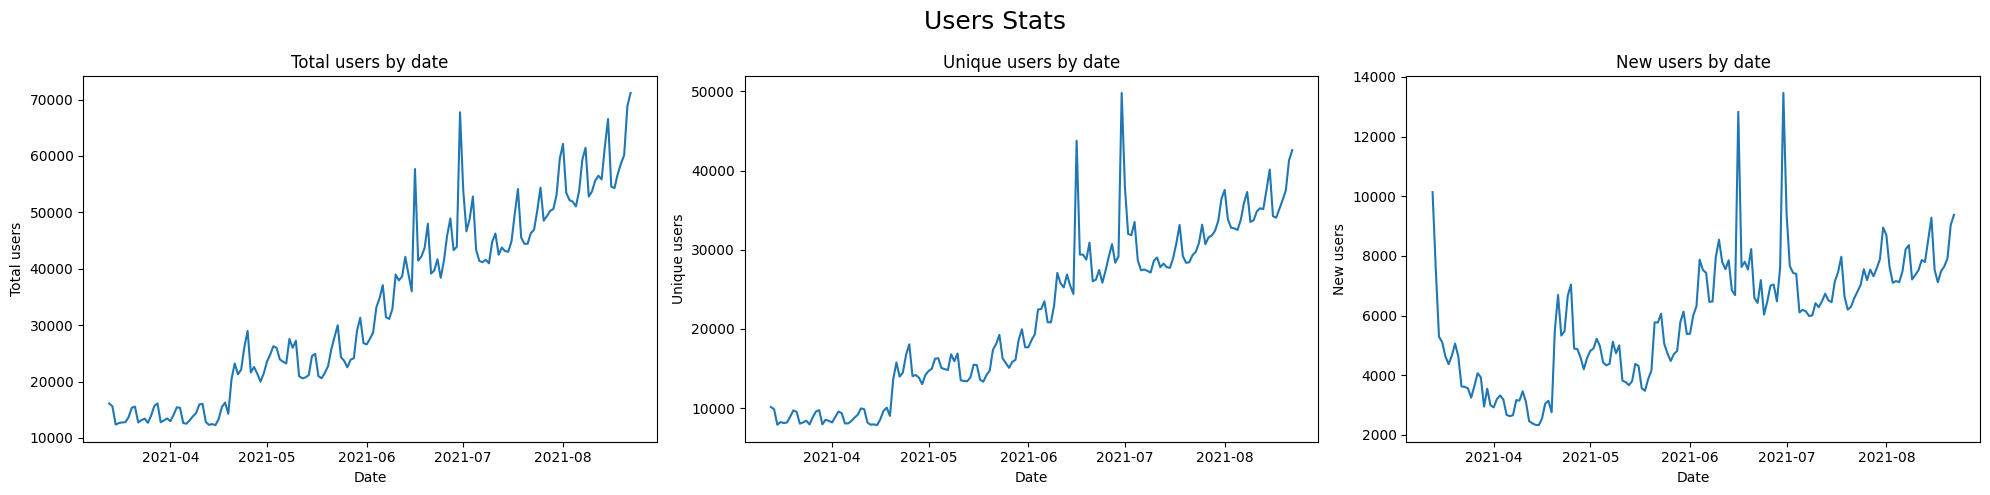

In [88]:
user_stats = interactions.group_by("last_watch_dt").agg(
    [
        pl.col("user_id").count().alias("total_users"),
        pl.col("user_id").n_unique().alias("unique_users"),
    ]
)

first_appearance = interactions.group_by("user_id").agg(
    pl.col("last_watch_dt").min().alias("first_date")
)

new_users_per_date = (
    first_appearance.group_by("first_date")
    .agg(pl.count("user_id").alias("new_users"))
    .sort("first_date")
    .rename({"first_date": "last_watch_dt"})
)

user_stats = user_stats.join(
    new_users_per_date, on="last_watch_dt", how="left"
).fill_null(0)

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)
fig.suptitle("Users Stats", fontsize=18)

sns.lineplot(data=user_stats, x="last_watch_dt", y="total_users", ax=axes[0])
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Total users")
axes[0].set_title("Total users by date")

sns.lineplot(data=user_stats, x="last_watch_dt", y="unique_users", ax=axes[1])
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Unique users")
axes[1].set_title("Unique users by date")

sns.lineplot(data=user_stats, x="last_watch_dt", y="new_users", ax=axes[2])
axes[2].set_xlabel("Date")
axes[2].set_ylabel("New users")
axes[2].set_title("New users by date")

plt.tight_layout()
plt.show()


- Видно, что у нас есть юзеры, которые взаимодействуют много раз в течении дня (График 1)
- Также есть те, кто взаимодействует только один раз (График 2)
- И, конец, присутствуют холодные юзеры, которые на определенную дату впервые взаимодействуют с платформой (График 3)


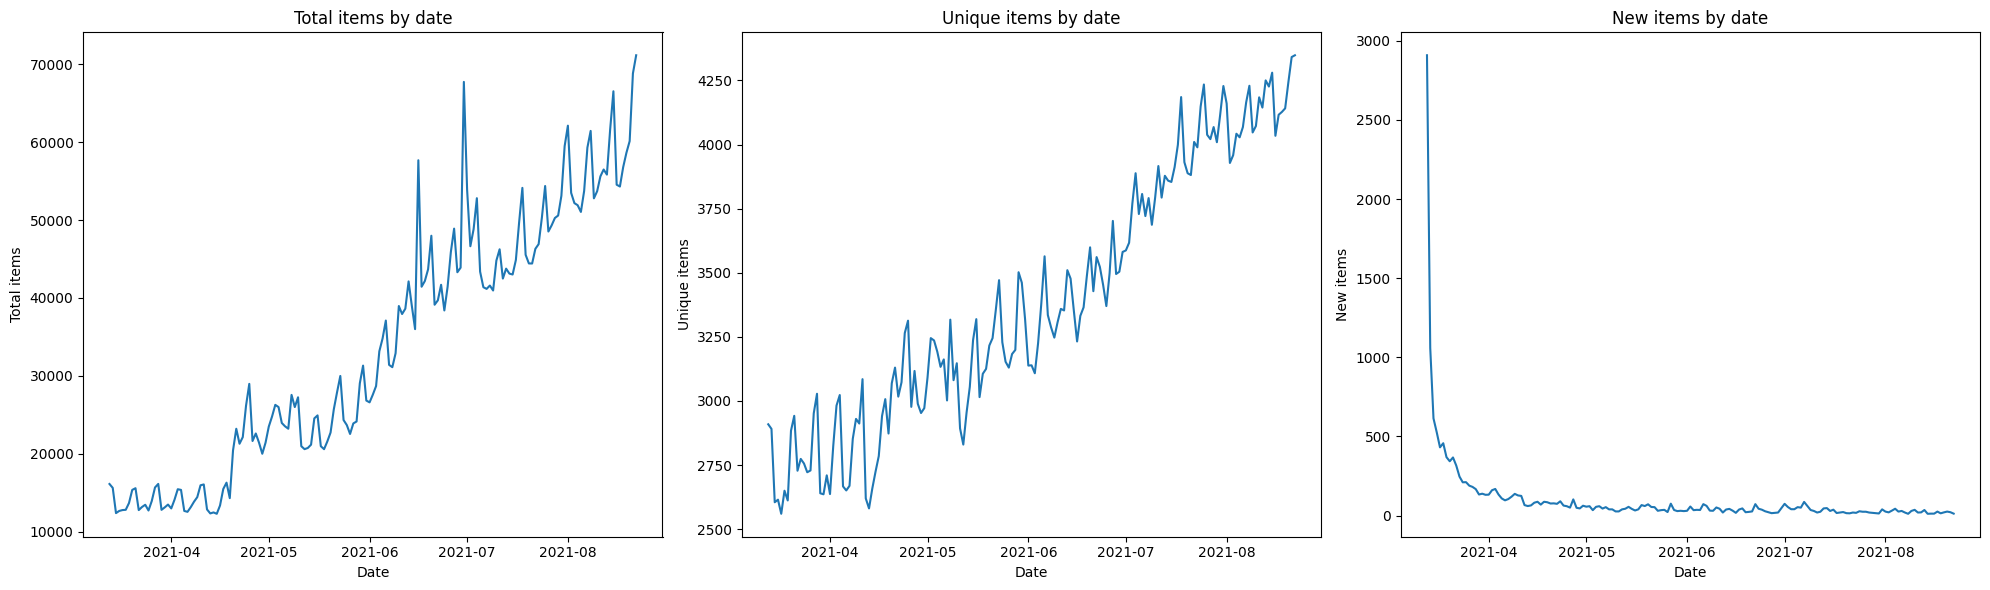

In [89]:
# Обьекты
item_stats = interactions.group_by("last_watch_dt").agg(
    [
        pl.col("item_id").count().alias("total_items"),
        pl.col("item_id").n_unique().alias("unique_items"),
    ]
)

first_item_appearance = interactions.group_by("item_id").agg(
    pl.col("last_watch_dt").min().alias("first_date")
)

new_items_per_date = (
    first_item_appearance.group_by("first_date")
    .agg(pl.count("item_id").alias("new_items"))
    .sort("first_date")
    .rename({"first_date": "last_watch_dt"})
)

item_stats = item_stats.join(
    new_items_per_date, on="last_watch_dt", how="left"
).fill_null(0)

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

sns.lineplot(data=item_stats, x="last_watch_dt", y="total_items", ax=axes[0])
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Total items")
axes[0].set_title("Total items by date")

sns.lineplot(data=item_stats, x="last_watch_dt", y="unique_items", ax=axes[1])
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Unique items")
axes[1].set_title("Unique items by date")

sns.lineplot(data=item_stats, x="last_watch_dt", y="new_items", ax=axes[2])
axes[2].set_xlabel("Date")
axes[2].set_ylabel("New items")
axes[2].set_title("New items by date")

plt.tight_layout()
plt.show()

- Результаты примерно такие же по динамике, однако холодных обьектов в разы меньше


## Submissions data


In [90]:
submission_data.head(2)

user_id,item_id
i64,str
3,"""[9728, 15297, 10440, 14488, 13…"
11,"""[9728, 15297, 10440, 14488, 13…"


In [91]:
# Lets look of how many new users are in the submission data

interactions_users = set(interactions["user_id"].unique())
submission_users = set(submission_data["user_id"].unique())

new_users = submission_users - interactions_users

new_users_count = len(new_users)
total_users_count = len(submission_users)
percent_new_users = new_users_count / total_users_count * 100


print(f"New users in submission data: {new_users_count} ({percent_new_users:.1f}%)")
print(f"Total users in submission data: {len(submission_users)}")

New users in submission data: 64943 (33.6%)
Total users in submission data: 193113


- Около 66к новых юзеров из 193к, то бишь 33.6%


In [92]:
items.null_count()

item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_range
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [93]:
# Final asserst for missing values

assert interactions.null_count().to_numpy().sum() == 0
assert items.null_count().to_numpy().sum() == 0
assert users.null_count().to_numpy().sum() == 0
assert submission_data.null_count().to_numpy().sum() == 0

In [94]:
x = Path.cwd().parent / "data"
x.exists()


True

In [95]:
# Convert to parquet
path_to_save = Path.cwd().parent / "data" / "modified_data"

interactions.write_parquet(path_to_save / "interactions.parquet")
items.write_parquet(path_to_save / "items.parquet")
users.write_parquet(path_to_save / "users.parquet")
submission_data.write_parquet(path_to_save / "submission_data.parquet")
